Call value is $133.41 with SE +/- 8.26


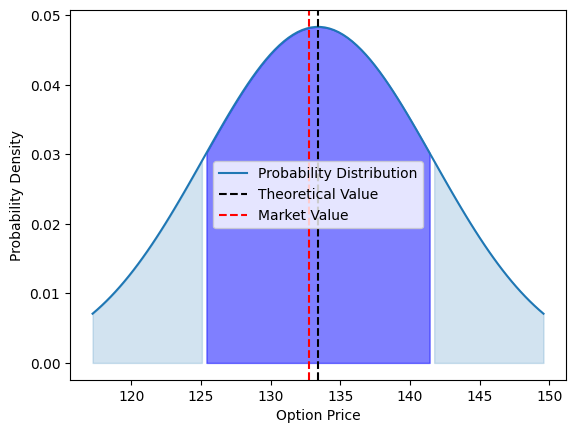

Implied Volatility: 13.539064038085938


In [3]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf

# We create a ticker object for the stock
ticker = yf.Ticker("NVDA")

# Then Retrieve historical price data
data = ticker.history(period="1mo")

# We get current stock price
S = current_price = data['Close'].iloc[-1]

# The expiration date
expiration_dates = ticker.options
# First available expiration
expiration_date = expiration_dates[0]

# Ticker option chain
options_chain = ticker.option_chain(expiration_date)
call_options = options_chain.calls

# We get the strike price and volatility
K = call_options.iloc[0]['strike']
vol = call_options.iloc[0]['impliedVolatility']
vol = max(vol, 1e-6)
if vol < 0.01: vol = 0.2

# We assume a constant risk-free rate (r=0.05 for the US Treasury yield)
r = 0.05

# We calculate the time to expiration in years
exp_date = datetime.datetime.strptime(expiration_date, "%Y-%m-%d").date()
T = (exp_date - datetime.date.today()).days / 365

if T <= 0: raise ValueError("The selected option has already expired.")

# Monte Carlo Simulation parameters
N = 10      # Number of steps
M = 1000      # Number of simulations
# Market price of option
market_value = call_options.iloc[0]['lastPrice']

# Necessary constants
dt = T / N
nudt = (r - 0.5 * vol**2) * dt
volsdt = vol * np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Simulation
Z = np.random.normal(size=(N, M))
delta_lnSt = nudt + volsdt * Z
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.vstack([np.full(M, lnS), lnSt])  # Add initial price

# We compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r * T) * np.mean(CT[-1])
sigma = np.std(CT[-1], ddof=1)
SE = sigma / np.sqrt(M)

print(f"Call value is ${C0:.2f} with SE +/- {SE:.2f}")

# Define confidence interval
confidence_interval = 1.96

# Generate probability distribution
x_min = C0 - confidence_interval * SE
x_max = C0 + confidence_interval * SE
x = np.linspace(x_min, x_max, 100)
pdf = norm.pdf(x, C0, SE)

# Plots
plt.plot(x, pdf, color='tab:blue', label='Probability Distribution')
plt.axvline(x=C0, color='k', linestyle='--', label='Theoretical Value')
plt.axvline(x=market_value, color='r', linestyle='--', label='Market Value')
plt.fill_between(x, pdf, where=(x > C0 + SE), color='tab:blue', alpha=0.2)
plt.fill_between(x, pdf, where=(x < C0 - SE), color='tab:blue', alpha=0.2)
plt.fill_between(x, pdf, where=((x >= C0 - SE) & (x <= C0 + SE)), color='blue', alpha=0.5)
plt.ylabel("Probability Density")
plt.xlabel("Option Price")
plt.legend()
plt.show()

print(f"Implied Volatility: {vol}")
#print(f"Market Price of Call Option: ${market_value:.2f}")